**Deep Learing Assignment 2**

19232697: Saurabh Shashikant Hebbalkar

In [0]:
#Importing the required libraries
from absl import logging
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Load all files from a directory into a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add sentiment column.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["sentiment"] = 1
  neg_df["sentiment"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

In [0]:
# Reduce logging output.
logging.set_verbosity(logging.ERROR)

#Load the dataset
train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment
0,"Once in the Life means that once a hoodlum, al...",1
1,"OK, I kinda like the idea of this movie. I'm i...",0
2,Rawhide was a wonderful TV western series. Foc...,1
3,My only minor quibble with the film I grew up ...,1
4,William Cooke and Paul Talbot share director/w...,0


In [0]:
#Combining test and train data into one dataframe
frames = [train_df, test_df]
combined_df = pd.concat(frames)

In [0]:
#Data preprocessing and removing the unwanted data

#Removing line break> tags 
combined_df['sentence'] = combined_df['sentence'].str.replace('<br />','')
#Removing Numbers
combined_df['sentence'] = combined_df['sentence'].str.replace('\d+', '')
#Removing -- character
combined_df['sentence'] = combined_df['sentence'].str.replace("--", '')
#Removing Punctuations
combined_df['sentence'] = combined_df['sentence'].str.replace('[^\w\s]','')
#Converting to Lowercase
combined_df['sentence'] = combined_df['sentence'].str.lower()
#Removing Stop words
combined_df['sentence'].apply(lambda x: [item for item in x if item not in stop])


In [0]:
#Converting each value in a label to a number
label_encoder = preprocessing.LabelEncoder()
combined_df['sentiment'] = label_encoder.fit_transform(combined_df['sentiment'])
combined_df.head()

,sentence,sentiment
0,once in the life means that once a hoodlum alw...,1
1,ok i kinda like the idea of this movie im in t...,0
2,rawhide was a wonderful tv western series focu...,1
3,my only minor quibble with the film i grew up ...,1
4,william cooke and paul talbot share directorwr...,0


In [0]:
#Preparing data for Modelling and Test Train Split
sentences = np.array(combined_df['sentence'])
labels = np.array(combined_df['sentiment'])

In [0]:
#Splitting the data in to test and train with 30% for test and 70% for train
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, shuffle=True)
print("Training : ",len(X_train), len(y_train))
print("Testing : ",len(X_test), len(y_test))

Training :  35000 35000
Testing :  15000 15000


In [0]:
# choose hyper parameters to tune
vocab_size = 10000
embedding_dim = 150
max_length =  400 
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

# import Tokenizer & fit on training text
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# convert text to sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
# Add padding to the X_train
training_padded = pad_sequences(training_sequences, maxlen = max_length,
                                padding = padding_type,
                                truncating = trunc_type)
# Add padding to the X_test
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length,
                                padding = padding_type,
                                truncating = trunc_type)


In [0]:
# LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 150)          1500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 400, 128)          110080    
_________________________________________________________________
dropout (Dropout)            (None, 400, 128)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 400, 128)          512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 128)          0         
_________________________________________________________________
dense (Dense)                (None, 400, 128)          16512     
_________________________________________________________________
dense_1 (Dense)              (None, 400, 1)            1

In [0]:
# Compile model
model.compile(loss = 'binary_crossentropy',
            optimizer = Adam(learning_rate=0.001),
            metrics = ['accuracy'])

# Training model
num_epochs = 10
history = model.fit(training_padded, y_train,
                    epochs=num_epochs,
                    batch_size = 512,
                    validation_data = (testing_padded, y_test),
                    verbose=1)

Epoch 1/10
69/69 [==============================] - 17s 242ms/step - loss: 0.5364 - accuracy: 0.6941 - val_loss: 0.5466 - val_accuracy: 0.8608
Epoch 2/10
69/69 [==============================] - 16s 232ms/step - loss: 0.2539 - accuracy: 0.9049 - val_loss: 0.5223 - val_accuracy: 0.8804
Epoch 3/10
69/69 [==============================] - 16s 230ms/step - loss: 0.1960 - accuracy: 0.9299 - val_loss: 0.4135 - val_accuracy: 0.8761
Epoch 4/10
69/69 [==============================] - 16s 229ms/step - loss: 0.1685 - accuracy: 0.9420 - val_loss: 0.3371 - val_accuracy: 0.8727
Epoch 5/10
69/69 [==============================] - 16s 230ms/step - loss: 0.1458 - accuracy: 0.9508 - val_loss: 0.3303 - val_accuracy: 0.8678
Epoch 6/10
69/69 [==============================] - 16s 229ms/step - loss: 0.1259 - accuracy: 0.9589 - val_loss: 0.3574 - val_accuracy: 0.8644
Epoch 7/10
69/69 [==============================] - 16s 228ms/step - loss: 0.1146 - accuracy: 0.9630 - val_loss: 0.3617 - val_accuracy: 0.8671

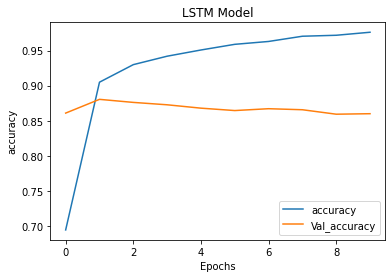

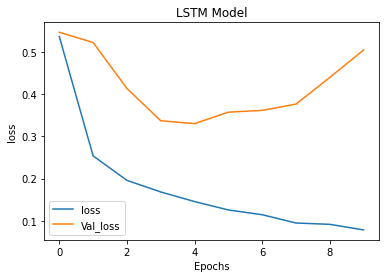

<Figure size 432x288 with 0 Axes>

In [0]:
#Plotting the LSTM performance graph
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.title("LSTM Model")
    plt.legend([string, 'Val_' + string])
    plt.show()
    plt.savefig(string)
    
plot_graphs(history, "accuracy")
plot_graphs(history,"loss")

In [0]:
# Naive Model: Simple RNN

model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    
    # Simple RNN
    tf.keras.layers.SimpleRNN(128, activation='tanh'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 150)          1500000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               35712     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,535,841
Trainable params: 1,535,841
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile model
model_2.compile(loss = 'binary_crossentropy',
            optimizer = SGD(),
            metrics = ['accuracy'])

# Training model
num_epochs = 10
history = model_2.fit(training_padded, y_train,
                    epochs=num_epochs,
                    validation_data = (testing_padded, y_test),
                    batch_size = 512,
                    verbose=1)

Epoch 1/10
69/69 [==============================] - 37s 532ms/step - loss: 0.6940 - accuracy: 0.4975 - val_loss: 0.6936 - val_accuracy: 0.5023
Epoch 2/10
69/69 [==============================] - 37s 533ms/step - loss: 0.6937 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.5006
Epoch 3/10
69/69 [==============================] - 37s 529ms/step - loss: 0.6935 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4993
Epoch 4/10
69/69 [==============================] - 37s 533ms/step - loss: 0.6933 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.5029
Epoch 5/10
69/69 [==============================] - 36s 524ms/step - loss: 0.6932 - accuracy: 0.5070 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 6/10
69/69 [==============================] - 36s 527ms/step - loss: 0.6930 - accuracy: 0.5065 - val_loss: 0.6933 - val_accuracy: 0.5007
Epoch 7/10
69/69 [==============================] - 36s 525ms/step - loss: 0.6929 - accuracy: 0.5031 - val_loss: 0.6932 - val_accuracy: 0.5035

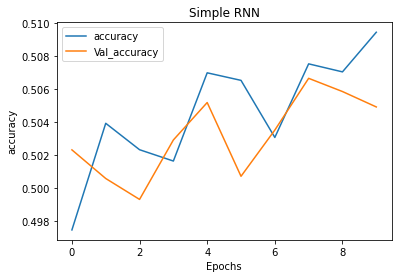

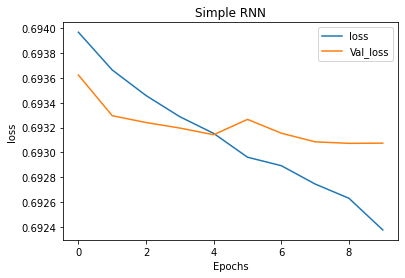

In [0]:
#Plotting the Simple RNN performance graph
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.title("Simple RNN")
    plt.legend([string, 'Val_' + string])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history,"loss")